# Classification of chest X-ray scans

The aim of this project is to classify chest X-ray scans coming from patients suffering from COVID or pneumonia, or from healthy subjects (control). For the classification, deep learning using convolutional neuronal networks was used. More specifically, a pre-trained model, VGG-16, was modified and employed by using transfer learning. 

Load modules

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

np.random.seed(42)
tf.random.set_seed(42)

Load one image to check its size and values

In [2]:
from PIL import Image
file = r"Covid19-dataset\train\Normal\1.png"
image = Image.open(file)   
print(type(image))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [3]:
data = np.asarray(image)

print('Size of the file:', data.shape)

print('Minimum pixel value:', data[:,:,:3].min())

print('Maximum pixel value:', data[:,:,:3].max())



Size of the file: (256, 256, 4)
Minimum pixel value: 0
Maximum pixel value: 255


The image has a width and height of 256 pixels, with pixel values ranging from 0 to 255. Let's see why the last dimension is 4:

In [4]:
print(data[:5,:5,:])

[[[  9   9   9 255]
  [  9   9   9 255]
  [ 11  11  11 255]
  [ 19  19  19 255]
  [ 18  18  18 255]]

 [[ 15  15  15 255]
  [ 11  11  11 255]
  [ 13  13  13 255]
  [ 11  11  11 255]
  [ 11  11  11 255]]

 [[ 12  12  12 255]
  [ 12  12  12 255]
  [ 11  11  11 255]
  [ 15  15  15 255]
  [ 14  14  14 255]]

 [[  8   8   8 255]
  [ 11  11  11 255]
  [ 13  13  13 255]
  [ 13  13  13 255]
  [ 17  17  17 255]]

 [[ 15  15  15 255]
  [ 11  11  11 255]
  [ 13  13  13 255]
  [  9   9   9 255]
  [ 14  14  14 255]]]


The files have 3 channels, such as an RGB picture, but all channels have the same pixel values, so the images are basically grayscale. The 4th channel is populated by the value 255.

Create an Image Data Generator, which can additionally augment the images by zooming, rotating and shifting them.

In [5]:
# ImageDataGenerator

height, width = 224, 224 # this is the default size of input to the VGG-16
batch_size=16 # faster than for 64 and with similar results

#create an ImageDataGenerator with augmented images
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255,
        zoom_range=0.05,
        rotation_range=2,
        width_shift_range=0.05,
        height_shift_range=0.05
        )
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        target_size=(height, width),
        class_mode='categorical', # classes will be [1,0,0], [0,1,0], [0,0,1]; works with loss='categorical_crossentropy'
        classes={'Normal': 0, 'Pneumonia': 1,'Covid': 2}
    )
    return generator
dir = 'Covid19-dataset/'
TRAINING_DIR = dir + '/train'
TESTING_DIR = dir + '/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

#total_image = np.concatenate([train_generator.labels,test_generator.labels])

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Make sure the shape of a batch in the generator has the proper size (16 images, 224 width, 224 height and 3 channels)

In [6]:
train_generator[0][0].shape

(16, 224, 224, 3)

Check how balanced the data sets are

In [7]:
print('Train set:',{'Normal_cases':len(np.where(train_generator.labels==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(train_generator.labels==1)[0]),
             'Covid_cases':len(np.where(train_generator.labels==2)[0])})

print('Test set:', {'Normal_cases':len(np.where(test_generator.labels==0)[0]),
      'Viral_Pneumonia_cases':len(np.where(test_generator.labels==1)[0]),
             'Covid_cases':len(np.where(test_generator.labels==2)[0])})

Train set: {'Normal_cases': 70, 'Viral_Pneumonia_cases': 70, 'Covid_cases': 111}
Test set: {'Normal_cases': 20, 'Viral_Pneumonia_cases': 20, 'Covid_cases': 26}


Visualize a couple of images

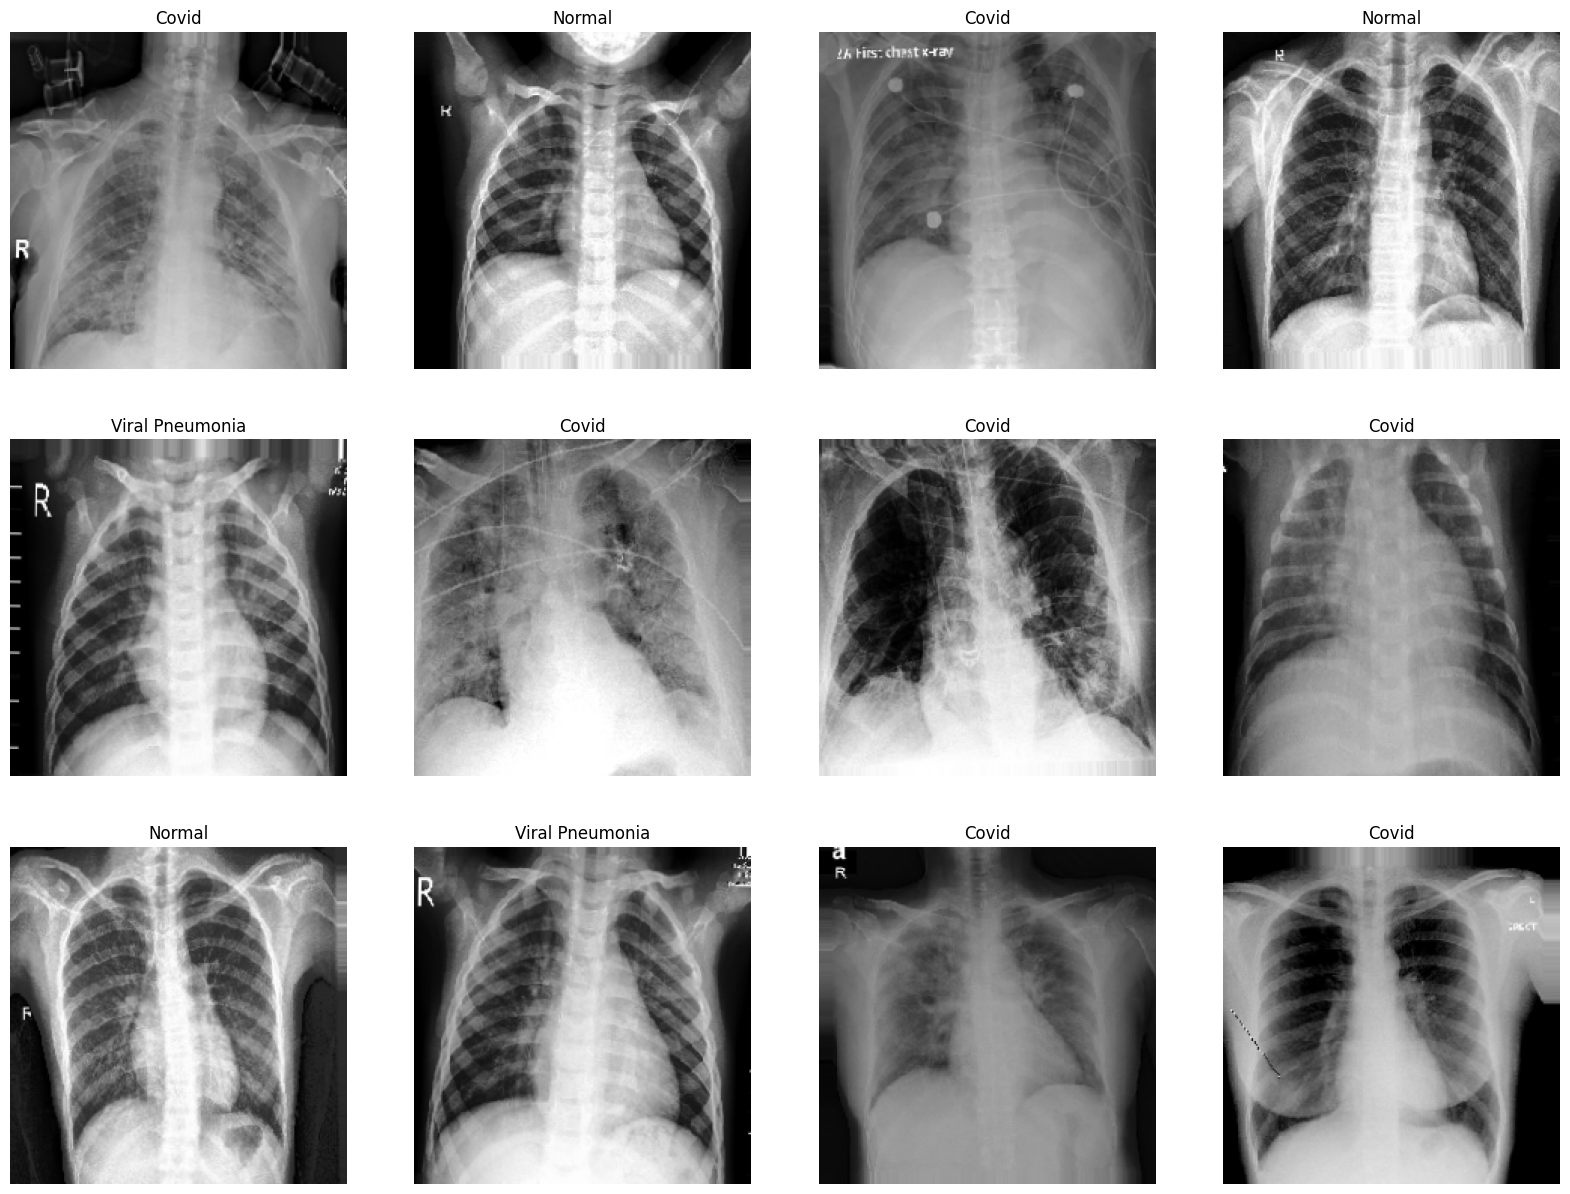

In [8]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]
    img_label = np.argmax(img_label,axis=1)

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,12)

Design a modle based on VGG-16, with 2 more dense layers with 256 units and 2 dropout layersto preventing overfitting. This model gave better results than other models with different numbers of dense layers or amount of units.

In [9]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3) # rgb
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False, # if include_top=False, input_shape can be different thant the default (224,224,3)
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())

model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.005),
              # measuring accuracy only to be able to save the best model
              metrics=['acc', 'AUC'])#tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]) 

    
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [10]:
st = time.time()
#saving works only with acc available as metric
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=8)

callbacks_list = [checkpoint,es]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        epochs=40,
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)
et = time.time()  

Epoch 1/40
16/16 [==============================] - ETA: 0s - loss: 1.3536 - acc: 0.3267 - auc: 0.5006
Epoch 1: acc improved from -inf to 0.32669, saving model to model\vgg16_best.h5
16/16 [==============================] - 43s 3s/step - loss: 1.3536 - acc: 0.3267 - auc: 0.5006 - val_loss: 0.9428 - val_acc: 0.5152 - val_auc: 0.7429
Epoch 2/40
16/16 [==============================] - ETA: 0s - loss: 0.8927 - acc: 0.5538 - auc: 0.7665
Epoch 2: acc improved from 0.32669 to 0.55378, saving model to model\vgg16_best.h5
16/16 [==============================] - 25s 2s/step - loss: 0.8927 - acc: 0.5538 - auc: 0.7665 - val_loss: 0.7361 - val_acc: 0.5455 - val_auc: 0.8165
Epoch 3/40
16/16 [==============================] - ETA: 0s - loss: 0.7126 - acc: 0.6813 - auc: 0.8577
Epoch 3: acc improved from 0.55378 to 0.68127, saving model to model\vgg16_best.h5
16/16 [==============================] - 24s 2s/step - loss: 0.7126 - acc: 0.6813 - auc: 0.8577 - val_loss: 0.5268 - val_acc: 0.7576 - val_auc:

16/16 [==============================] - ETA: 0s - loss: 0.2799 - acc: 0.8845 - auc: 0.9789
Epoch 27: acc did not improve from 0.90438
16/16 [==============================] - 31s 2s/step - loss: 0.2799 - acc: 0.8845 - auc: 0.9789 - val_loss: 0.1698 - val_acc: 0.9242 - val_auc: 0.9940


In [11]:
print('Model training duration:{0:6.1f} s'.format(et-st))

Model training duration:1280.4 s


Plot the learning curve of categorical accuracy and AUC

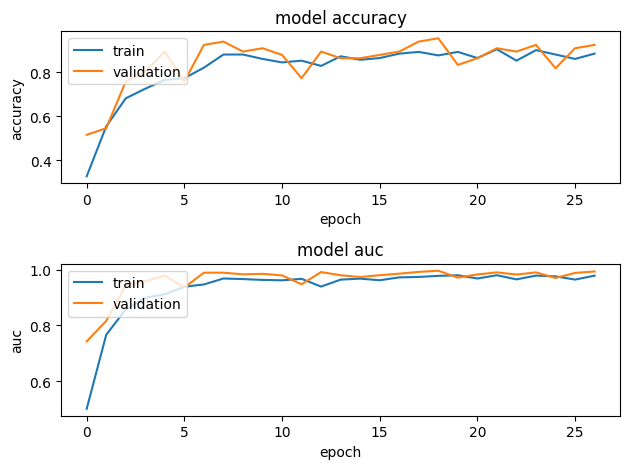

In [12]:
def plot_learning_curve(history):
# plotting categorical and validation accuracy over epochs

    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')
 
    # plotting auc and validation auc over epochs
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(history.history['auc'])
    ax2.plot(history.history['val_auc'])
    ax2.set_title('model auc')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('auc')
    ax2.legend(['train', 'validation'], loc='upper left')
 
    # used to keep plots from overlapping
    fig.tight_layout()
 
    fig.savefig('learning_curve.png')

plot_learning_curve(history)

In [13]:
# the best model, which is the last saved can be loaded here, or it can be continued with the current model
#model_vgg16 = tf.keras.models.load_model('model/vgg16_best.h5')

In [14]:
train_result = model_vgg16.evaluate(train_generator)
test_result = model_vgg16.evaluate(test_generator)

score = pd.DataFrame(zip(train_result,test_result),columns=['Train','Val'],index=['Loss','Acc', 'AUC'])
score

5/5 [==============================] - 7s 1s/step - loss: 0.1846 - acc: 0.9394 - auc: 0.9931


,Train,Val
Loss,0.110073,0.184576
Acc,0.964143,0.939394
AUC,0.997873,0.993056


Calculate different scores (precision, recall, f1-score, accuracy) and plot the confusion matrix for the test dataset

3/3 [==============================] - 6s 2s/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20
           2       1.00      1.00      1.00        26

    accuracy                           0.97        66
   macro avg       0.97      0.97      0.97        66
weighted avg       0.97      0.97      0.97        66



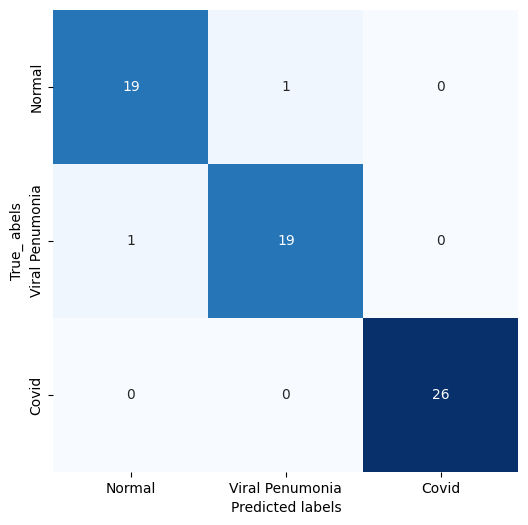

In [15]:
y_test = []
x_test = []

for i in range(math.ceil(len(test_generator.classes)/batch_size)):
    x_test.append(test_generator[i][0]) 
    y_test.append(test_generator[i][-1])

x_test = np.concatenate((x_test),axis=0)
y_test = np.concatenate((y_test), axis = 0)
y_test = np.argmax(y_test, axis = 1)

y_pred_prob =model_vgg16.predict(x_test)
y_pred = np.argmax(y_pred_prob,axis=1)

plt.figure(figsize=(6, 6))
hm = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])  
hm.set(xlabel='Predicted labels')
hm.set(ylabel='True_ abels')
print(classification_report(y_test,y_pred))

Very interestingly, the model can classify Covid cases with 100% precision and recall, meaning that it can successfully distinguish between Covid and Viral pneumonia, whose symptoms might be otherwise somewhat similar. Normal and Viral pneumonia cases are also predicted with high precision and recall (95%). The higher score for Covid cases migh be related to the higher number of Covid images (111) in comparison to normal (70) or viral pneumonia (70) used to train the model.

Visualization of wrongly categorized images

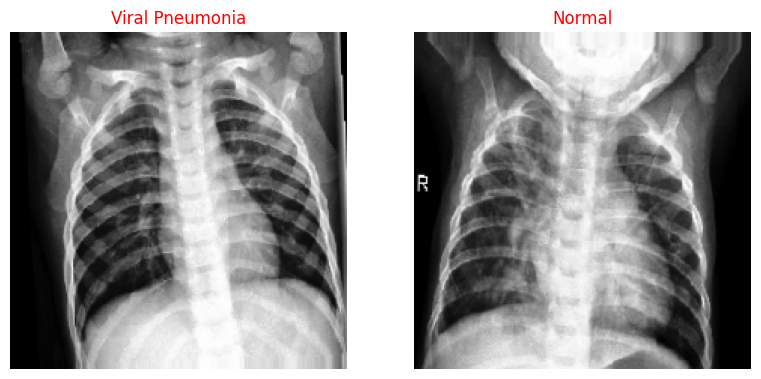

In [16]:
#Extract wrong classification index
wrong_pred = np.where(y_pred!=y_test)[0]

plt.figure(figsize=(20, 15))
for i,n in enumerate(wrong_pred):
    ax = plt.subplot(math.ceil(len(wrong_pred)/4),4, i + 1)
    plt.imshow(x_test[n])
    plt.title("Normal" if y_pred[n] == 0 else "Viral Pneumonia" if y_pred[n] == 1 else "Covid",color='r')
    plt.axis("off")



Overall, the model does a great job. It could be employed together with other information (symptoms, medical tests) for diagnostics.